MediaGamma - Take Home Test
======

Qikai Gu

July 17, 2018


The test is about building a CTR prediction model with one of provided datasets. 
I picked [https://www.kaggle.com/c/avazu-ctr-prediction](https://www.kaggle.com/c/avazu-ctr-prediction).

It's expected to:
- finish the test in 2-3 hours
- return the results in 2 weeks but the sooner the better
- build an end-to-end pipeline for the task
- showcase my understanding of various aspects of ML: ETL, model building and selection, evaluation, etc.
- develop in python (jupyter notebooks) with reasonable comments
- use version control with appropriate commit messages

Last updated: July 29, 2018

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import xlearn as xl
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import FeatureHasher, HashingVectorizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import scipy
from scipy.special import logit, expit
import matplotlib.pyplot as plt
import gc

%matplotlib inline

### Loading data

In [2]:
# Use only 'train.gz' here as we need labeled data to evaluate our models.
df = pd.read_csv('input/train.gz', # nrows=100000,
                 compression='gzip', dtype={'id': str}, index_col='id')

In [ ]:
pd.set_option('display.max_columns', 100)
df.head()

In [ ]:
print('dataset shape: \t{}'.format(df.shape))

### Preprocessing & Feature engineering

Check class balance, it seems the class imbalance is not so bad.

In [ ]:
df.click.value_counts()

In [3]:
m0, m1 = df.click.value_counts()

Show features and types

In [ ]:
pd.set_option('display.max_rows', 30)
df.dtypes

Check if there's any NaN values

In [ ]:
for col in df.columns:
    print('{:20}: {}'.format(col, df[col].hasnans))

Negative samples downsampling

As the provided data is 10 days click-through data. I will use the first 8 days as traning set, 9th day as valid set and the last day as test set.

In [ ]:
df.hour.unique()

In [4]:
neg_ids = df[df.click == 0].index
np.random.seed(42)
drop_indices = np.random.choice(neg_ids, m0 - m1, replace=False)
df.drop(drop_indices, inplace=True)

Define Train/Valid/Test indices

In [5]:
train_ids = df[(df.hour >= 14102100) & (df.hour < 14102900)].index
valid_ids = df[(df.hour >= 14102900) & (df.hour < 14103000)].index
test_ids = df[df.hour >= 14103000].index

train_indices = df.index.get_indexer(train_ids)
valid_indices = df.index.get_indexer(valid_ids)
test_indices = df.index.get_indexer(test_ids)

# define combined train and val set for cross-validation
train_val_ids = np.concatenate([train_ids, valid_ids])
train_val_indices = np.concatenate([train_indices, valid_indices])

Add hour as a new feature

In [6]:
df['hour_h'] = df.hour.apply(lambda x: x % 100)

In [7]:
label_path = 'label.csv'
label_file = Path(label_path)
if label_file.is_file():
    label_df = pd.read_csv(label_path).set_index('id')
else:
    label_df = df[['click']]
    label_df.to_csv(label_path)

Plot the top value counts of the features

In [ ]:
def plot_value_counts(series, title='', size=30):
    cnts = series.values[:size]
    x = range(len(cnts))
    plt.plot(x, cnts, 'o')
    plt.yscale('log')
    plt.ylim(1e2)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plt.rcParams['figure.figsize'] = (9.0, 5.0)
for col in ['device_id', 'device_ip', 'device_model']:
    plot_value_counts(df[col].value_counts(), title='{} top value counts'.format(col))

In [8]:
fields = df.columns[1:]

Print some more information about device.

In [ ]:
for col in ['device_type', 'device_conn_type']:
    print(df[col].value_counts())

It looks good, there aren't too many levels.

### Train test split

Test set is randomly selected. I use a dictionary to store sub training sets. To time reason, I only put 6 subsets, but we can add more subsets if needed.

In [9]:
%%time

filepath = 'dataset.npz'
dataset_file = Path(filepath)
if dataset_file.is_file():
    sparse_matrix = scipy.sparse.load_npz(filepath)
else:
    vectors = []
    for c in fields:
        n_features = min(1000, df[c].nunique())
        h = HashingVectorizer(n_features=n_features, binary=True, norm=None, lowercase=False)
        sparse_vector = h.transform(df[c].astype(str))
        vectors.append(sparse_vector)
    sparse_matrix = scipy.sparse.hstack(vectors).tocsr()
    scipy.sparse.save_npz(filepath, sparse_matrix)

CPU times: user 10min 57s, sys: 4.71 s, total: 11min 1s
Wall time: 11min 1s


### Building and training models

I will use train a Logistic Regression model and a XGBoost model and evaluate them with ROC AUC scores. For FFM model, I previously used the xLearn framework to build and train the model, but as it's not very stable and non-deterministic for multi-threading for the current version, I won't use it in this notebook.

Logistic Regression model

In [8]:
%%time

lr = LogisticRegression(solver='saga')
lr.fit(sparse_matrix[train_indices, :], df.loc[train_ids].click)

CPU times: user 9min 14s, sys: 2.26 s, total: 9min 16s
Wall time: 9min 16s


In [9]:
print('Train auc:')
roc_auc_score(df.loc[train_ids].click, 
              lr.predict_proba(sparse_matrix[train_indices, :])[:, 1])

Train auc:


0.7465672730378365

In [10]:
print('Valid auc')
roc_auc_score(df.loc[valid_ids].click, 
              lr.predict_proba(sparse_matrix[valid_indices, :])[:, 1])

Valid auc


0.7217943812354648

In [12]:
pred_lr = lr.predict_proba(sparse_matrix[test_indices, :])[:, 1]

In [14]:
roc_auc_score(df.loc[test_ids].click, pred_lr)

0.7256734163609524

XGBoost model

In [17]:
xgb_model = xgb.XGBClassifier(n_estimators=1000, 
                              early_stopping_rounds=10,
                              learning_rate=0.3, 
                              n_jobs=-1, 
                              random_state=42)

parameters = {'max_depth': [7, 9],
              'subsample': [0.8, 0.9],
              'colsample_bytree': [0.8]}

gs_xgb = GridSearchCV(xgb_model, parameters, cv=[(train_indices, valid_indices)], 
                      scoring='roc_auc', verbose=2)
gs_xgb.fit(sparse_matrix[train_val_indices, :], label_df.loc[train_val_ids].click)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] colsample_bytree=0.8, max_depth=7, subsample=0.8 ................
[CV] . colsample_bytree=0.8, max_depth=7, subsample=0.8, total=44.3min
[CV] colsample_bytree=0.8, max_depth=7, subsample=0.9 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 46.5min remaining:    0.0s


[CV] . colsample_bytree=0.8, max_depth=7, subsample=0.9, total=44.1min
[CV] colsample_bytree=0.8, max_depth=9, subsample=0.8 ................
[CV] . colsample_bytree=0.8, max_depth=9, subsample=0.8, total=56.7min
[CV] colsample_bytree=0.8, max_depth=9, subsample=0.9 ................
[CV] . colsample_bytree=0.8, max_depth=9, subsample=0.9, total=56.8min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 211.9min finished


GridSearchCV(cv=[(array([       0,        1, ..., 11038512, 11038513]), array([11038514, 11038515, ..., 12299305, 12299306]))],
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=10, gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [7, 9], 'subsample': [0.8, 0.9], 'colsample_bytree': [0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [18]:
gs_xgb.best_score_

0.7495953565751019

In [19]:
gs_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, early_stopping_rounds=10, gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [21]:
pred_xgb = gs_xgb.predict_proba(sparse_matrix[test_indices, :])[:, 1]

In [23]:
roc_auc_score(label_df.loc[test_ids].click, pred_xgb)

0.741085047022664

### Evaluation

I use AUC as evaluation metric. This metric evaluates the ranking ability of the CTR, which can reduce the impact of bias.

In [25]:
y_true = label_df.loc[test_ids].click.values

# fpr_lr, tpr_lr, _ = roc_curve(y_true, pred_lr)
# roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_xgb, tpr_xgb, _ = roc_curve(y_true, pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

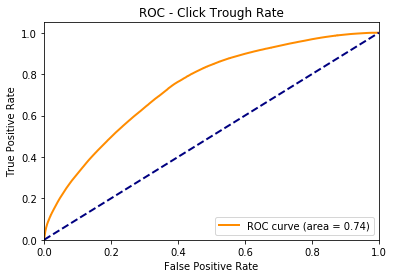

In [26]:
plt.figure()
lw = 2
# plt.plot(fpr_lr, tpr_lr, color='black',
#          lw=lw, label='LR (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr_xgb, tpr_xgb, color='darkorange',
         lw=lw, label='XGB (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Click Trough Rate')
plt.legend(loc="lower right")
plt.show()

Without compound features, XGBoost (0.74) performs slightly better than Logistic Regression (0.72).